In [1]:
import math
import random
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.io


# Root directory of the project
ROOT_DIR = os.path.abspath("..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from src.mrcnn import utils
import src.mrcnn.model as modellib
from src.mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import src.mrcnn.coco as coco

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights", "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\f

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index("teddy bear")
class_names = ["BG", "person", "bicycle", "car", "motorcycle", "airplane",
               "bus", "train", "truck", "boat", "traffic light",
               "fire hydrant", "stop sign", "parking meter", "bench", "bird",
               "cat", "dog", "horse", "sheep", "cow", "elephant", "bear",
               "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
               "suitcase", "frisbee", "skis", "snowboard", "sports ball",
               "kite", "baseball bat", "baseball glove", "skateboard",
               "surfboard", "tennis racket", "bottle", "wine glass", "cup",
               "fork", "knife", "spoon", "bowl", "banana", "apple",
               "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza",
               "donut", "cake", "chair", "couch", "potted plant", "bed",
               "dining table", "toilet", "tv", "laptop", "mouse", "remote",
               "keyboard", "cell phone", "microwave", "oven", "toaster",
               "sink", "refrigerator", "book", "clock", "vase", "scissors",
               "teddy bear", "hair drier", "toothbrush"]

Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


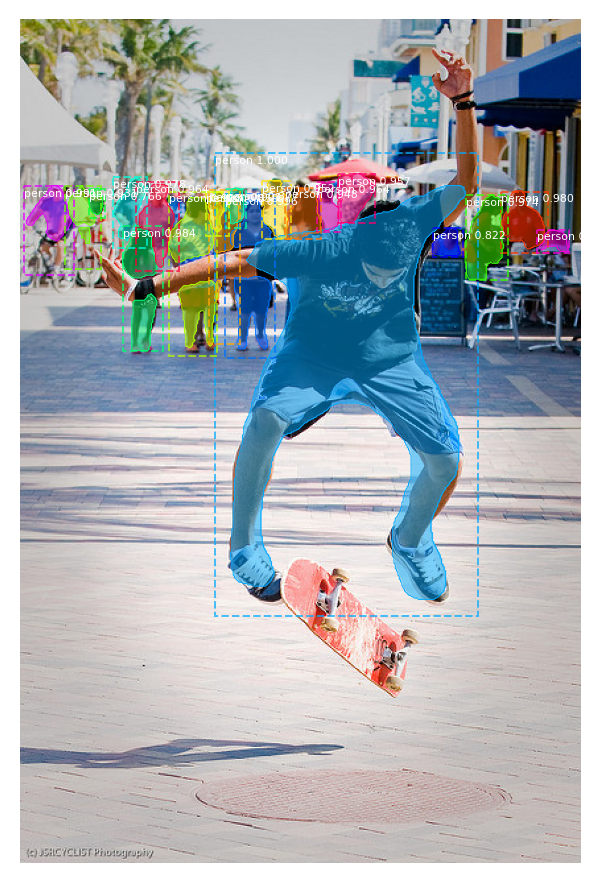

In [5]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r["rois"], r["masks"], r["class_ids"], 
                            class_names, r["scores"])

In [6]:
import cv2

In [16]:
def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


# based on https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py
# and https://github.com/markjay4k/Mask-RCNN-series/blob/887404d990695a7bf7f180e3ffaee939fbd9a1cf/visualize_cv.py
def display_instances(image, boxes, masks, class_ids, class_names, scores=None):
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
    
    N = boxes.shape[0]
    c = (0, 255, 0)
    counter = 0

    for i in range(N):
        if not np.any(boxes[i]):
            continue
        
        y1, x1, y2, x2 = boxes[i]
        label = class_names[class_ids[i]]
        if label != "person":
            continue
        score = scores[i] if scores is not None else None
        caption = "{} {:.3f}".format(label, score) if score else label
        counter += 1

        # Mask
        mask = masks[:, :, i]
        image = apply_mask(image, mask, c)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), c, 2)
        image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, c, 2)

    image = cv2.putText(image, str(counter), (0, 20), cv2.FONT_HERSHEY_COMPLEX, 0.7, c, 2)
    return image

In [9]:
VIDEO_PATH = os.path.join(ROOT_DIR, "videos", "People_sample_2.mp4")

In [11]:
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
output_path = f"{os.path.splitext(VIDEO_PATH)[0]}_mrcnn.avi"


In [12]:
vid_writer = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc("M", "J", "P", "G"),
    fps,
    (
        round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    ),
)

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1280.00000


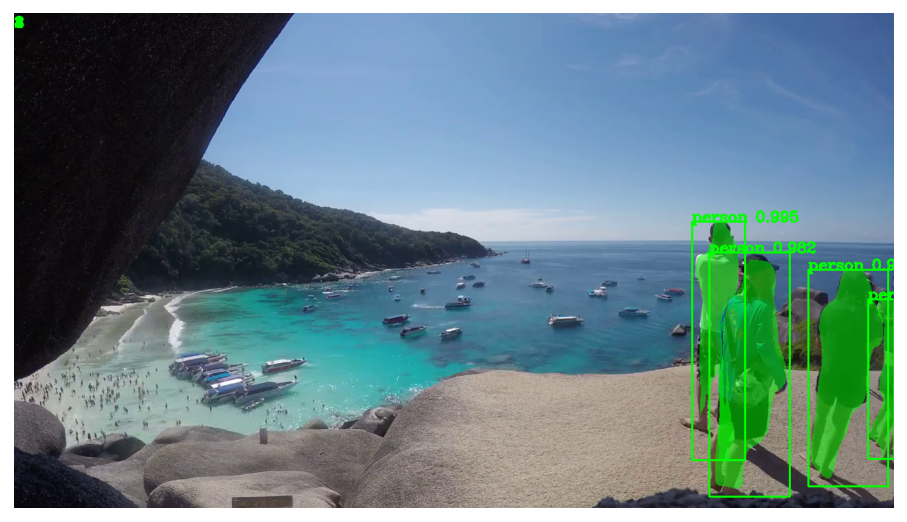

In [17]:
has_frame, frame = cap.read()
results = model.detect([frame], verbose=1)
r = results[0]
frame = display_instances(frame, r["rois"], r["masks"], r["class_ids"], class_names, r["scores"])

_, ax = plt.subplots(1, figsize=(16, 16))
height, width = frame.shape[:2]
ax.set_ylim(height + 10, -10)
ax.set_xlim(-10, width + 10)
ax.axis("off")
ax.imshow(frame[:, :, ::-1])


In [31]:
sec = 0
while True:
    cap.set(1, sec * fps)
    # Get frame from the video
    has_frame, frame = cap.read()

    # Stop the program if reached end of video
    if not has_frame:
        print("Done processing !!!")
        print(f"Output file is stored as {output_path}")
        break

    results = model.detect([frame], verbose=1)
    r = results[0]
    frame = display_instances(frame, r["rois"], r["masks"], r["class_ids"], class_names, r["scores"])

    # Write the frame with the detection boxes
    vid_writer.write(frame.astype(np.uint8))
    sec += 1
cap.release()

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1280.00000
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1280.00000
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1280.00000
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)